# Práctica: CNN con CIFAR-10

---

## Contexto empresarial: DragonVision

La empresa tecnológica **DragonVision**, con sede en Shangai, está desarrollando una nueva
plataforma de **clasificación inteligente de imágenes**. El objetivo es crear modelos capaces de:

- Reconocer distintos tipos de objetos en imágenes de baja resolución.
- Reconstruir imágenes a partir de representaciones comprimidas (codificadas).

El departamento de I+D ha decidido usar el dataset **CIFAR-10**, un conjunto de imágenes pequeñas
(32x32 píxeles y 3 canales de color) que contiene 10 categorías distintas:

- Avión, automóvil, pájaro, gato, ciervo, perro, rana, caballo, barco, camión.

En esta práctica, tú formas parte del equipo de DragonVision y tu misión es:

1. Realizar un **análisis exploratorio** básico sobre el dataset CIFAR-10.
2. Diseñar, entrenar y evaluar una **red neuronal convolucional (CNN)** que clasifique correctamente estas imágenes.
3. Entregar un informe formato PDF

---

## Objetivos de aprendizaje

Al finalizar esta práctica deberías ser capaz de:

- Cargar y explorar un dataset de imágenes (`tf.keras.datasets.cifar10`).
- Entender la forma y el rango de valores de los tensores de imágenes.
- Diseñar una **CNN** simple para clasificación de imágenes:
  - Preparación de datos
  - Definición de la arquitectura
  - Compilación, entrenamiento, visualización de métricas
  - Evaluación en un conjunto de test
- Diseñar un **autoencoder convolucional** (encoder + decoder deconvolucional) que:
  - Comprima una imagen en un espacio latente
  - La reconstruya a partir de esa representación comprimida
- Interpretar una **batería de pruebas automáticas** sobre tus modelos y comprender por qué son aptos o no.

In [137]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix

np.random.seed(42)

# ============================================================
# Cargar CIFAR-10 COMPLETO (50k train + 10k test) y crear val
# Guardarlo en un .npz grande para reutilizarlo sin red
# ============================================================

FULL_PATH = "cifar10_full.npz"

if os.path.exists(FULL_PATH):
    # Si ya existe el fichero grande, lo cargamos
    data = np.load(FULL_PATH)
    x_train = data["X_train"]
    y_train = data["y_train"]
    x_val   = data["X_val"]
    y_val   = data["y_val"]
    x_test  = data["X_test"]
    y_test  = data["y_test"]
else:
    # Si no existe, lo descargamos con Keras y lo guardamos en .npz
    (x_train_all, y_train_all), (x_test, y_test) = keras.datasets.cifar10.load_data()

    # Crear validación a partir de train (por ejemplo 5.000 para val)
    val_size = 5000
    idx = np.random.permutation(x_train_all.shape[0])

    val_idx = idx[:val_size]
    tr_idx  = idx[val_size:]

    x_val = x_train_all[val_idx]
    y_val = y_train_all[val_idx]

    x_train = x_train_all[tr_idx]
    y_train = y_train_all[tr_idx]

    # Guardar en disco para futuras ejecuciones
    np.savez_compressed(
        FULL_PATH,
        X_train=x_train, y_train=y_train,
        X_val=x_val,     y_val=y_val,
        X_test=x_test,   y_test=y_test
    )

    # Para mantener el mismo flujo del notebook (data existe)
    data = np.load(FULL_PATH)

# Nombres de las clases en el orden de CIFAR-10
class_names = [
    "avión", "automóvil", "pájaro", "gato", "ciervo",
    "perro", "rana", "caballo", "barco", "camión"
]


## 1. Análisis Exploratorio de Datos (EDA) en CIFAR-10

En este apartado explorarás el dataset CIFAR-10 para entender mejor:

- Cómo son las dimensiones de las imágenes.
- En qué rango se mueven los valores de los píxeles.
- Cómo se distribuyen las clases.
- Ejemplos visuales de varias imágenes con sus etiquetas.

Recuerda que estamos trabajando con **imágenes en color** de tamaño **32x32** y **3 canales**.


### 1.1 Formas y tipos básicos

In [138]:
# Objetivo: comprender la estructura de x_train, y_train, x_test, y_test.

# TODO:
# 1) Imprime el tipo de datos (dtype) de x_train y y_train.
# 2) Imprime el número de imágenes de entrenamiento y de test.
#    Pista: usa shape[0].

# Escribe tu código debajo de este comentario:

print("x_train dtype:", x_train.dtype)
print("y_train dtype:", y_train.dtype)

print("Nº imágenes train:", x_train.shape[0])
print("Nº imágenes test :", x_test.shape[0])

x_train dtype: uint8
y_train dtype: uint8
Nº imágenes train: 45000
Nº imágenes test : 10000


### 1.2 Rango de valores de los píxeles

In [139]:
# Objetivo: saber cuál es el valor mínimo y máximo de los píxeles (antes de normalizar).

# TODO:
# 1) Calcula el valor mínimo de x_train.
# 2) Calcula el valor máximo de x_train.
#    Pista: utiliza np

# Escribe tu código debajo:
min_val = x_train.min()
max_val = x_train.max()

print("Min pixel value (x_train):", min_val)
print("Max pixel value (x_train):", max_val)


Min pixel value (x_train): 0
Max pixel value (x_train): 255


### 1.3 Distribución de clases

In [140]:
# Objetivo: comprobar cuántas imágenes hay de cada clase en el conjunto de entrenamiento.

# y_train tiene forma (num_imágenes, 1). Para contar, conviene aplanarlo:
y_train_flat = y_train.flatten()

# TODO:
# Muestra el resultado de forma legible, indicando el nombre de la clase.
# Ejemplo de salida:
#   Clase 0 (avión): 5000 imágenes
#   Clase 1 (automóvil): 5000 imágenes

# Pista: puedes recorrer con un bucle for y usar class_names[i].

# Escribe tu código debajo:
counts = np.bincount(y_train_flat, minlength=len(class_names))

for i, c in enumerate(counts):
    print(f"Clase {i} ({class_names[i]}): {c} imágenes")



Clase 0 (avión): 4524 imágenes
Clase 1 (automóvil): 4513 imágenes
Clase 2 (pájaro): 4473 imágenes
Clase 3 (gato): 4477 imágenes
Clase 4 (ciervo): 4514 imágenes
Clase 5 (perro): 4496 imágenes
Clase 6 (rana): 4515 imágenes
Clase 7 (caballo): 4491 imágenes
Clase 8 (barco): 4497 imágenes
Clase 9 (camión): 4500 imágenes


### 1.4 Visualización de algunas imágenes

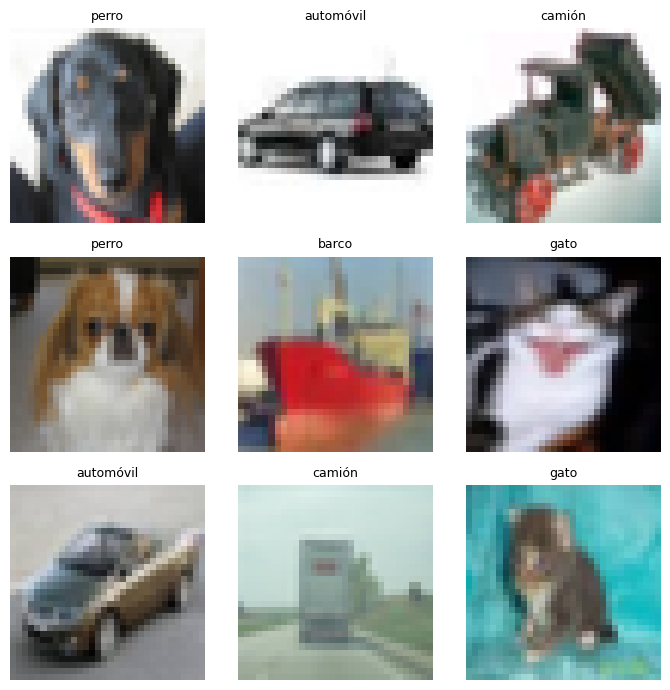

In [141]:
# Objetivo: visualizar varias imágenes con sus etiquetas para hacernos una idea del dataset.

# TODO:
# 1) Selecciona 'i' índices aleatorios del conjunto de entrenamiento.
# 2) Dibuja una cuadrícula 3x3 con plt.subplot(3, 3, i+1)
# 3) Usa plt.imshow() para mostrar la imagen (recuerda que son imágenes en color RGB).
# 4) Título: nombre de la clase (usa class_names[label]) y opcionalmente el índice.

# Pista: para quitar los ejes, usa plt.axis("off").

# Escribe tu código debajo:
idxs = np.random.choice(x_train.shape[0], size=9, replace=False)

plt.figure(figsize=(7, 7))
for j, idx in enumerate(idxs):
    plt.subplot(3, 3, j + 1)
    plt.imshow(x_train[idx])
    label = int(y_train[idx]) if np.ndim(y_train[idx]) == 0 else int(y_train[idx][0])
    plt.title(class_names[label], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()




### 1.5 De cara a enriquecer el PDF, comenta:

- Si las clases parecen balanceadas o no.
- Qué te llama la atención al ver las imágenes.
- Antes de crear la Red Neuronal, ¿por qué crees que puede ser un reto clasificar estas imágenes correctamente?
- A priori, ¿crees que será más fácil clasificar estas imágenes que las del catálogo de ropa?

---


## 2. Red Convolucional (CNN) para clasificación de CIFAR-10

En este bloque vas a construir una **CNN** capaz de predecir la clase de cada imagen de CIFAR-10.

Pasos a seguir:

1. Preparar los datos (normalización, posible reducción de tamaño del dataset, separación train/validación).
2. Diseñar la arquitectura de la CNN.
3. Compilar el modelo.
4. Entrenar la red (guardando el historial de entrenamiento).
5. Visualizar la evolución de las métricas (pérdida y accuracy).
6. Evaluar el modelo en el conjunto de test.

> OJO: para que el entrenamiento sea razonablemente rápido en los ordenadores del aula, es recomendable
> usar solo una parte de `x_train` (por ejemplo, 10.000 imágenes para entrenar y 2.000 para validación).
---


### 2.1 Preparación de datos para la CNN

In [142]:
# Recomendación (no obligatorio): reducir el tamaño del dataset para acelerar el entrenamiento (y que no te vaya a pedales el ordenador).

# Pistas:
# - Usa slicing.
# - Normaliza los píxeles al rango [0, 1] dividiendo entre 255.0.

# Nombres de variables:
# - X_train_cnn, y_train_cnn
# - X_val_cnn,   y_val_cnn
# - X_test_cnn,  y_test_cnn

# TODO:
# 1) Crear subconjunto de entrenamiento y validación a partir de x_train, y_train.
# 2) Normalizar X_train_cnn, X_val_cnn y X_test_cnn al rango [0,1].
# 3) Asegurarte de que y_train_cnn, y_val_cnn y y_test_cnn tienen un formato válido para Keras.

# Escribe tu código debajo:

X_train_cnn = x_train.astype("float32") / 255.0
y_train_cnn = y_train.astype("int32").flatten()

X_val_cnn   = x_val.astype("float32") / 255.0
y_val_cnn   = y_val.astype("int32").flatten()

X_test_cnn = x_test
y_test_cnn = y_test

print("Shapes:")
print("X_train_cnn:", X_train_cnn.shape, "y_train_cnn:", y_train_cnn.shape)
print("X_val_cnn  :", X_val_cnn.shape,   "y_val_cnn  :", y_val_cnn.shape)
print("X_test_cnn :", X_test_cnn.shape,  "y_test_cnn :", y_test_cnn.shape)

print("X dtype:", X_train_cnn.dtype)
print("X min/max:", X_train_cnn.min(), X_train_cnn.max())
print("X mean/std:", X_train_cnn.mean(), X_train_cnn.std())




Shapes:
X_train_cnn: (45000, 32, 32, 3) y_train_cnn: (45000,)
X_val_cnn  : (5000, 32, 32, 3) y_val_cnn  : (5000,)
X_test_cnn : (10000, 32, 32, 3) y_test_cnn : (10000, 1)
X dtype: float32
X min/max: 0.0 1.0
X mean/std: 0.47360075 0.25156763


### 2.2 Diseño de la arquitectura CNN

In [143]:
# En esta celda debes definir una red convolucional que reciba imágenes de tamaño (32, 32, 3)
# y produzca una salida de 10 clases.
#
# Sugerencias:
# - Uso de keras.Sequential()
# - Capas tipo Conv2D, MaxPooling2D, Flatten, Dense y si lo crees necesario (Dropout, etc.)

# El modelo DEBE llamarse: cnn_model

# Ejemplo de estructura (solo guía, NO copiar literalmente):
# cnn_model = keras.Sequential([
#     layers.Conv2D(...),
#     layers.MaxPool2D(...),
#     ...
#     layers.Flatten(),
#     layers.Dense(...),
#     layers.Dense(10, activation="softmax")
# ])

# TODO: define aquí tu modelo cnn_model

# Después de definirlo, muestra un resumen del modelo con summary()
cnn_model = keras.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Bloque 1 (features simples)
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.20),

    # Bloque 2 (features intermedias)
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.30),

    # Bloque 3 (features más abstractas)
    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.40),

    # Clasificador
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.50),
    layers.Dense(10, activation="softmax")
])

cnn_model.summary()




Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 814,122 (3.11 MB)

 Trainable params: 814,122 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

### 2.3 Compilación de la CNN

In [144]:
# Ahora debes compilar el modelo indicada la función de pérdida, el optimizador y las métricas.

# Sugerencias:
# - Optimizador: "adam" (u otro que te guste).
# - Pérdida:
#    - "sparse_categorical_crossentropy" si tus etiquetas son enteros 0-9.
#    - "categorical_crossentropy" si has convertido las etiquetas a one-hot.
# - Métricas: ["accuracy"] para empezar.

# TODO: compila cnn_model con los parámetros que consideres adecuados.

# Ejemplo de guía (NO copiar literal):
# cnn_model.compile(
#     optimizer=...,
#     loss=...,
#     metrics=[...]
# )
cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)



### 2.4 Entrenamiento de la CNN

In [145]:
# Entrena tu modelo cnn_model usando los datos:
#   - X_train_cnn, y_train_cnn
#   - X_val_cnn,   y_val_cnn
#
# Es importante que guardes el historial de entrenamiento en una variable llamada history_cnn.

# Sugerencias:
# - epochs entre 5 y 20 (en función del tiempo que tengas y de la velocidad del ordenador).
# - batch_size típico: 64 o 128.

# TODO:
# 1) Entrenar el modelo cnn_model.
# 2) Guardar el resultado en history_cnn y usa fit.

history_cnn = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_val_cnn, y_val_cnn),
    epochs=10,
    batch_size=64,
    verbose=1
)


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.2593 - loss: 1.9479 - val_accuracy: 0.4892 - val_loss: 1.4022
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.5057 - loss: 1.3624 - val_accuracy: 0.5762 - val_loss: 1.1474
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.5807 - loss: 1.1736 - val_accuracy: 0.6356 - val_loss: 1.0100
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.6300 - loss: 1.0471 - val_accuracy: 0.6952 - val_loss: 0.8555
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6625 - loss: 0.9574 - val_accuracy: 0.7116 - val_loss: 0.7905
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6919 - loss: 0.8784 - val_accuracy: 0.7048 - val_loss: 0.8114
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.7062 - loss: 0.8351 - val_accuracy: 0.7304 - val_loss: 0.7696
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.7233 - loss: 0.7870 - 

### 2.5 Visualización de la evolución del entrenamiento

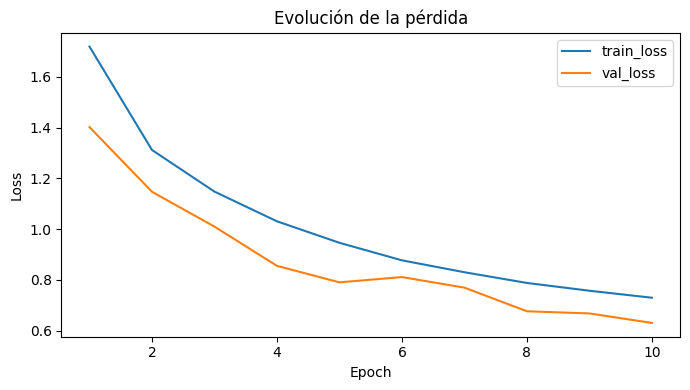

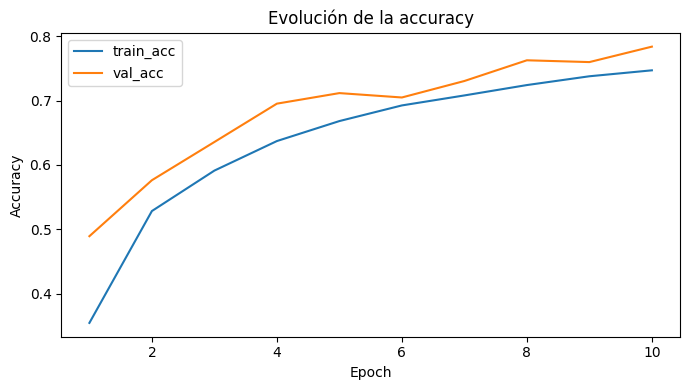

In [146]:
# A partir de history_cnn.history, representa:
# - La pérdida de entrenamiento y validación frente a las épocas.
# - La accuracy de entrenamiento y validación frente a las épocas (si la entrenaste).

# Pistas:
# - history_cnn.history es un diccionario con claves como "loss", "val_loss", "accuracy", "val_accuracy".
# - Puedes usar plt.plot() y plt.legend() para dibujar las curvas.

# TODO: dibuja las curvas de entrenamiento y validación (pérdida y accuracy).
hist = history_cnn.history
epochs = range(1, len(hist["loss"]) + 1)

# Pérdida
plt.figure(figsize=(7, 4))
plt.plot(epochs, hist["loss"], label="train_loss")
plt.plot(epochs, hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolución de la pérdida")
plt.legend()
plt.tight_layout()
plt.show()

# Accuracy (si existe)
if "accuracy" in hist:
    plt.figure(figsize=(7, 4))
    plt.plot(epochs, hist["accuracy"], label="train_acc")
    plt.plot(epochs, hist["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Evolución de la accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()


### 2.6 Evaluación de la CNN en el conjunto de test

In [147]:
# Ahora evalúa tu modelo cnn_model en el conjunto de test (X_test_cnn, y_test_cnn)
# y muestra la pérdida y la accuracy finales.

# TODO:
# 1) Evalúa cnn_model en X_test_cnn, y_test_cnn.
# 2) Imprime los resultados de forma legible.

# Pista:
# test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test_cnn)

# Asegura MISMO preprocesado en train/val/test
X_test_cnn = x_test.astype("float32") / 255.0
y_test_cnn = y_test.astype("int32").flatten()

X_val_cnn  = x_val.astype("float32") / 255.0
y_val_cnn  = y_val.astype("int32").flatten()

# (solo por seguridad, también train)
X_train_cnn = x_train.astype("float32") / 255.0
y_train_cnn = y_train.astype("int32").flatten()

print("X_test_cnn:", X_test_cnn.dtype, X_test_cnn.min(), X_test_cnn.max())
print("y_test_cnn:", y_test_cnn.dtype, y_test_cnn.shape, y_test_cnn.min(), y_test_cnn.max())

test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)



X_test_cnn: float32 0.0 1.0
y_test_cnn: int32 (10000,) 0 9
Test loss: 0.6645750999450684
Test accuracy: 0.7702000141143799


### En el informe de la práctica, incluye una sección dedicada a este bloque y responde de forma razonada con números a cuestiones como las siguientes:

> OJO: lo importante son los bloques, las preguntas como tal son sólo una guía para ayudarte a desarrollar el punto. Si respondes a algo más de lo que se pregunta, tendrás una mayor calificación

- **Preparación de datos**  
  Explica qué has hecho con el conjunto CIFAR-10 antes de entrenar:  
  - ¿Has usado todo el dataset o un subconjunto?  
  - ¿Cómo has normalizado las imágenes y por qué crees que es necesario hacerlo?

- **Diseño de la red**  
  Describe con tus palabras cómo es tu CNN: cuántas capas convolucionales y de pooling tiene, cuántas neuronas aproximadamente en la parte densa y qué papel crees que juegan las convoluciones y el pooling en este tipo de problemas de visión por ordenador.

- **Elección de hiperparámetros**  
  Comenta qué hiperparámetros clave has elegido (número de épocas, tamaño de batch, función de pérdida, optimizador…) y por qué te parecían opciones razonables para este problema. Si cambiaras alguno, ¿cuál sería y con qué objetivo?

- **Curvas de entrenamiento**  
  A partir de las gráficas de pérdida y accuracy (entrenamiento y validación), analiza cómo ha aprendido tu red:  
  - ¿Ves más signos de sobreajuste, de infraajuste o de un comportamiento razonable?  
  - ¿En qué detalles de las curvas te basas para llegar a esa conclusión?

- **Resultados en test y valoración global**  
  Resume los resultados numéricos que has obtenido en el conjunto de test y compáralos con los de entrenamiento y validación.  
  ¿Te parecen aceptables para un primer prototipo en la empresa DragonVision?  
  ¿Qué mejora concreta (de datos, arquitectura o entrenamiento) sería tu siguiente paso si tuvieras una sesión más de trabajo?

## 3. Análisis de errores de la CNN

Hasta ahora, hemos entrenado y evaluado nuestra red convolucional (CNN) para CIFAR-10,
pero solo nos hemos fijado en métricas agregadas como la **accuracy**.

En esta sección vamos a responder a preguntas más detalladas:

- ¿En qué clases acierta más la CNN?
- ¿En qué clases falla más?
- ¿Qué pares de clases se confunden con más frecuencia?
- ¿Cómo son visualmente algunas de las imágenes mal clasificadas?

Este análisis es clave en la empresa DragonVision para decidir en qué clases hay que
mejorar el modelo o recopilar más datos.

### 3.1 Cálculo de predicciones y matriz de confusión

In [148]:
# En esta celda vamos a:
# 1) Obtener las predicciones de la CNN sobre el conjunto de test.
# 2) Calcular la matriz de confusión usando sklearn.
#
# Recuerda:
# - y_test_cnn puede tener forma (N, 1), así que conviene aplanarlo con .flatten().
# - cnn_model.predict(X_test_cnn) te devuelve las probabilidades para cada clase.
# - np.argmax(..., axis=1) te da la clase de máxima probabilidad.
#
# Para la matriz de confusión vamos a usar sklearn.metrics.confusion_matrix.
# Pistas:
#   cm = confusion_matrix(y_true, y_pred)
#
# TODO:
# 1) Aplanar y_test_cnn en un vector y_true.
# 2) Calcular y_pred_proba con cnn_model.predict(X_test_cnn, ...).
# 3) Obtener y_pred a partir de y_pred_proba usando np.argmax(..., axis=1).
# 4) Calcular la matriz de confusión cm.
# 5) Imprimir las formas de y_true y y_pred, y mostrar cm por pantalla.

# TODO: 1) aplanar y_test_cnn
# y_true = ...
# print("Shape y_true:", y_true.shape)

# TODO: 2) obtener probabilidades de predicción de la CNN
# y_pred_proba = cnn_model.predict(...)

# TODO: 3) obtener clases predichas (enteros 0-9)
# y_pred = np.argmax(..., axis=1)
# print("Shape y_pred:", y_pred.shape)

# TODO: 4) calcular matriz de confusión
# cm = confusion_matrix(...)

# TODO: 5) imprimir la matriz de confusión
# print("Matriz de confusión (valores absolutos):")
# print(cm)
# 1) y_true
y_true = y_test_cnn.flatten()
print("Shape y_true:", y_true.shape)

# 2) probabilidades
y_pred_proba = cnn_model.predict(X_test_cnn, verbose=0)

# 3) clases predichas
y_pred = np.argmax(y_pred_proba, axis=1)
print("Shape y_pred:", y_pred.shape)

# 4) matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5) imprimir
print("Matriz de confusión (valores absolutos):")
print(cm)


Shape y_true: (10000,)
Shape y_pred: (10000,)
Matriz de confusión (valores absolutos):
[[812   6  51  13  11   1   7   9  63  27]
 [ 17 874   1   3   2   2   7   1  35  58]
 [ 79   0 654  26 105  34  70  11  12   9]
 [ 16   1  87 554  85 119  81  35  15   7]
 [ 20   1  65  32 768   4  53  46   9   2]
 [  7   2  83 145  66 621  27  39   5   5]
 [  7   1  43  31  35   2 876   0   2   3]
 [ 16   2  51  26  77  30   5 787   3   3]
 [ 46   7  16   7   5   3   3   0 899  14]
 [ 32  42   7  12   4   2   9   9  26 857]]


### 3.2. Dibujar la Matriz

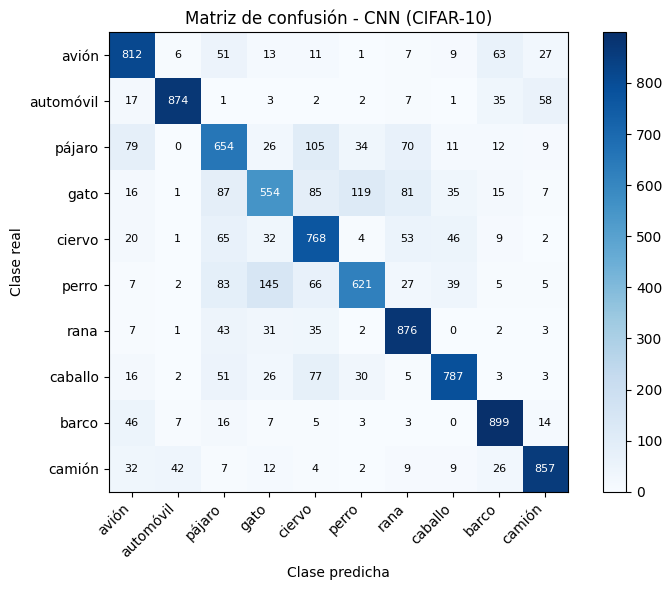

In [151]:
# En esta celda vas a representar la matriz de confusión cm como un mapa de calor.
#
# Pistas:
# - Usa plt.subplots() para crear la figura y los ejes.
# - Usa ax.imshow(cm, interpolation="nearest", cmap="Blues") para dibujar la matriz.
# - Añade una barra de color con plt.colorbar(im, ax=ax).
# - En el eje X: etiquetas de clases predichas.
# - En el eje Y: etiquetas de clases reales.
# - Usa ax.set_xticks(range(len(class_names))) y ax.set_xticklabels(class_names, rotation=45, ha="right").
# - Igual para el eje Y con set_yticks y set_yticklabels.
#
# TODO:
# 1) Crear la figura y los ejes.
# 2) Dibujar la matriz cm.
# 3) Añadir la barra de color.
# 4) Configurar ticks y etiquetas con class_names.
# 5) Añadir título y etiquetas de ejes.
# 6) Mostrar la figura.

# TODO: crear figura y ejes
# fig, ax = plt.subplots(...)

# TODO: dibujar la matriz de confusión
# im = ax.imshow(...)

# TODO: añadir barra de color
# plt.colorbar(...)

# TODO: configurar ticks y etiquetas (usa class_names)
# ax.set_xticks(...)
# ax.set_xticklabels(..., rotation=45, ha="right")
# ax.set_yticks(...)
# ax.set_yticklabels(...)

# TODO: añadir título y etiquetas de ejes
# ax.set_xlabel(...)
# ax.set_ylabel(...)
# ax.set_title(...)

# TODO: ajustar layout y mostrar
# plt.tight_layout()
# plt.show()
fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
plt.colorbar(im, ax=ax)

ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticks(range(len(class_names)))
ax.set_yticklabels(class_names)

ax.set_xlabel("Clase predicha")
ax.set_ylabel("Clase real")
ax.set_title("Matriz de confusión - CNN (CIFAR-10)")

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, str(cm[i, j]),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=8
        )

plt.tight_layout()
plt.show()


### 3.3 Aciertos por clases y visualización de clases mal clasificadas

Clase 0 (avión): accuracy = 0.8120  (muestras: 1000)
Clase 1 (automóvil): accuracy = 0.8740  (muestras: 1000)
Clase 2 (pájaro): accuracy = 0.6540  (muestras: 1000)
Clase 3 (gato): accuracy = 0.5540  (muestras: 1000)
Clase 4 (ciervo): accuracy = 0.7680  (muestras: 1000)
Clase 5 (perro): accuracy = 0.6210  (muestras: 1000)
Clase 6 (rana): accuracy = 0.8760  (muestras: 1000)
Clase 7 (caballo): accuracy = 0.7870  (muestras: 1000)
Clase 8 (barco): accuracy = 0.8990  (muestras: 1000)
Clase 9 (camión): accuracy = 0.8570  (muestras: 1000)

Mejor clase:
  8 (barco), accuracy = 0.8990
Peor clase:
  3 (gato), accuracy = 0.5540

=== Pares de clases más confundidas (real -> predicha) ===
Top 5 pares de clases más confundidas:

1. Real: 5 (perro)  Predicha: 3 (gato),  veces: 145
2. Real: 3 (gato)  Predicha: 5 (perro),  veces: 119
3. Real: 2 (pájaro)  Predicha: 4 (ciervo),  veces: 105
4. Real: 3 (gato)  Predicha: 2 (pájaro),  veces: 87
5. Real: 3 (gato)  Predicha: 4 (ciervo),  veces: 85

=== Visualiz

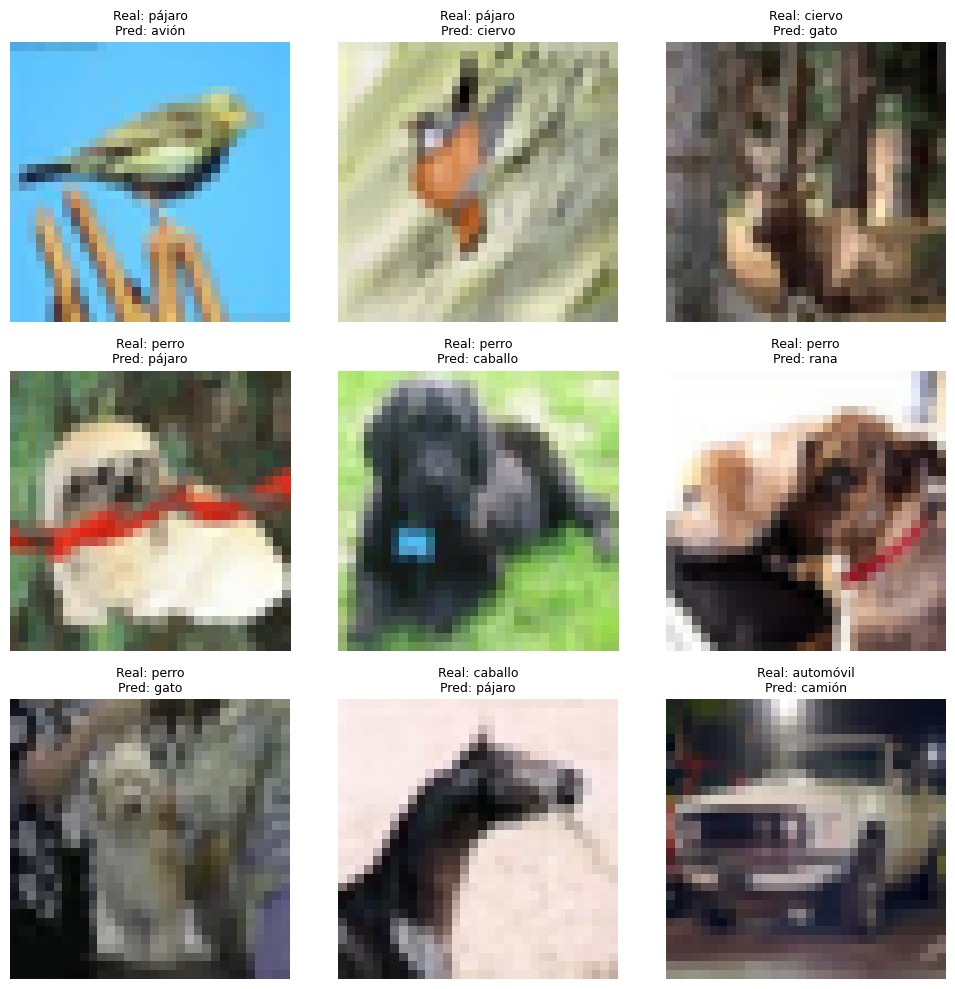

In [150]:
# Número de clases (debería coincidir con len(class_names) y cm.shape[0])
num_clases = len(class_names)

# Lista donde guardaremos la accuracy de cada clase
acc_por_clase = []

for c in range(num_clases):
    # Máscara booleana: True en las posiciones donde la etiqueta real es la clase c
    mask = (y_true == c)

    # Número total de muestras de la clase c
    total_c = mask.sum()

    if total_c == 0:
        # Por seguridad, si no hay muestras de esa clase (no debería pasar en CIFAR-10)
        acc_c = np.nan
    else:
        # Número de aciertos en la clase c
        aciertos_c = np.sum(y_pred[mask] == y_true[mask])
        # Accuracy de la clase c = aciertos / total
        acc_c = aciertos_c / total_c

    acc_por_clase.append(acc_c)

    print(f"Clase {c} ({class_names[c]}): accuracy = {acc_c:.4f}  (muestras: {total_c})")

# Índice de la mejor y peor clase (ignorando posibles NaN)
mejor_clase = int(np.nanargmax(acc_por_clase))
peor_clase = int(np.nanargmin(acc_por_clase))

print("\nMejor clase:")
print(f"  {mejor_clase} ({class_names[mejor_clase]}), accuracy = {acc_por_clase[mejor_clase]:.4f}")

print("Peor clase:")
print(f"  {peor_clase} ({class_names[peor_clase]}), accuracy = {acc_por_clase[peor_clase]:.4f}")

# ---------------------------------------------------------------------
# 3.4 Parejas de clases más confundidas
# ---------------------------------------------------------------------

print("\n=== Pares de clases más confundidas (real -> predicha) ===")

confusiones = []  # Lista de tuplas (clase_real, clase_predicha, veces_confundida)

# Recorremos todas las combinaciones de clases reales / predichas
for real in range(num_clases):
    for pred in range(num_clases):
        if real == pred:
            # La diagonal (real == pred) son aciertos, aquí buscamos SOLO errores
            continue

        # Veces que una imagen de clase 'real' se ha clasificado como 'pred'
        veces_confundida = cm[real, pred]

        if veces_confundida > 0:
            confusiones.append((real, pred, veces_confundida))

# Ordenamos la lista de confusiones de mayor a menor
confusiones_ordenadas = sorted(confusiones, key=lambda x: x[2], reverse=True)

# Mostramos las 5 confusiones más frecuentes
top_k = 5
print(f"Top {top_k} pares de clases más confundidas:\n")
for i in range(min(top_k, len(confusiones_ordenadas))):
    real, pred, veces = confusiones_ordenadas[i]
    print(f"{i+1}. Real: {real} ({class_names[real]})  "
          f"Predicha: {pred} ({class_names[pred]}),  veces: {veces}")

# ---------------------------------------------------------------------
# 3.5 Visualización de algunas imágenes mal clasificadas
# ---------------------------------------------------------------------

print("\n=== Visualización de algunas imágenes mal clasificadas ===")

# Índices de las muestras donde la CNN se ha equivocado
errores_idx = np.where(y_true != y_pred)[0]
num_errores = len(errores_idx)

print(f"Número total de imágenes mal clasificadas: {num_errores}")

if num_errores == 0:
    print("¡Enhorabuena! No se han encontrado errores en el conjunto de test.")
else:
    # Número de ejemplos a mostrar (puedes cambiar este valor si quieres ver más/menos)
    num_ejemplos = 9
    num_ejemplos = min(num_ejemplos, num_errores)

    # Seleccionamos índices aleatorios entre los errores
    ejemplos_idx = np.random.choice(errores_idx, size=num_ejemplos, replace=False)

    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(ejemplos_idx):
        plt.subplot(3, 3, i + 1)

        # Imagen de test (ya normalizada en [0,1])
        img = X_test_cnn[idx]

        # Etiquetas real y predicha (enteros 0-9)
        real_label = y_true[idx]
        pred_label = y_pred[idx]

        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"Real: {class_names[real_label]}\nPred: {class_names[pred_label]}",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()

### En el INFORME PDF escrito, responde a estas preguntas (no hace falta código aquí):

> OJO: lo importante son los bloques, las preguntas como tal son sólo una guía para ayudarte a desarrollar el punto. Si respondes a algo más de lo que se pregunta, tendrás una mayor calificación

¿Qué clases se clasifican mejor? ¿Cuáles peor?

¿Qué pares de clases se confunden más (real -> predicha)?

¿Qué posibles mejoras propondrías a la empresa para reducir esos errores?